# Segmentation with applied mask

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Mini Project/MiniProjectCode

/content/gdrive/.shortcut-targets-by-id/146s3V-pLOTkq77gy9eq9rbbdKmmphTFM/Mini Project/MiniProjectCode


In [3]:
!dir

5FoldOutput			    Reshaped_Dataset_OUTPUTS.ipynb
cardamom_dataset_5_Fold_Result.csv  sample_masked(s0).jpg
ClassifierModels_V(2).ipynb	    sample_masked(s6).jpg
data				    saved_5_fold_models
grape_dataset_5_Fold_Result.csv     saved_models
MasterU2Net.ipynb		    tensorboard
models				    trained_models_weight
output				    u2net_SegmentFolders.py
overridedOuptut			    u2net_util.py
__pycache__


In [ ]:
#caution :- will remove previous segmented
# !rm -rf output
# !rm -rf output_mask

In [ ]:
# !python -W ignore u2net_SegmentFolders.py --apply_mask True --batch_size 4 # batch size will be 2 powers
# !python -W ignore u2net_SegmentFolders.py --apply_mask True --batch_size 4 --output_size 384
# !python -W ignore u2net_SegmentFolders.py --apply_mask True --batch_size 4 --output_size 480
!python -W ignore u2net_SegmentFolders.py --apply_mask True --batch_size 4 --output_size 224

Segmenting:- grape_dataset
Segmenting:- .ipynb_checkpoints
Segmenting:- cardamom_dataset
Copied Already Segmented to output data/cardamom_dataset/train/Blight1000
Copied Already Segmented to output data/cardamom_dataset/test/Blight1000
Copied Already Segmented to output data/cardamom_dataset/val/Blight1000


In [4]:
%matplotlib inline
import cv2
import torch
import u2net_util
import numpy as np
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from torchvision import transforms
from u2net_util import U2NetPrediction,RescaleT

In [5]:
test_imageDir = './data/cardamom_dataset/test/Phylosticta_LS_1000/pls (139).jpg'
semanticSegmenter = U2NetPrediction()
semanticSegmenter.transform = transforms.Compose([RescaleT(320),transforms.ToTensor()])
image = io.imread(test_imageDir)
height,width = image.shape[:2]
mask = semanticSegmenter.semanticSegmentation(image = image,apply_mask=False)
masked = semanticSegmenter.semanticSegmentation(image = image,apply_mask=True)
S = semanticSegmenter.S


In [6]:
original = cv2.resize(image,(width,height))
mask = cv2.resize(mask,(width,height))
mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
masked = cv2.resize(masked,(width,height))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Visualization


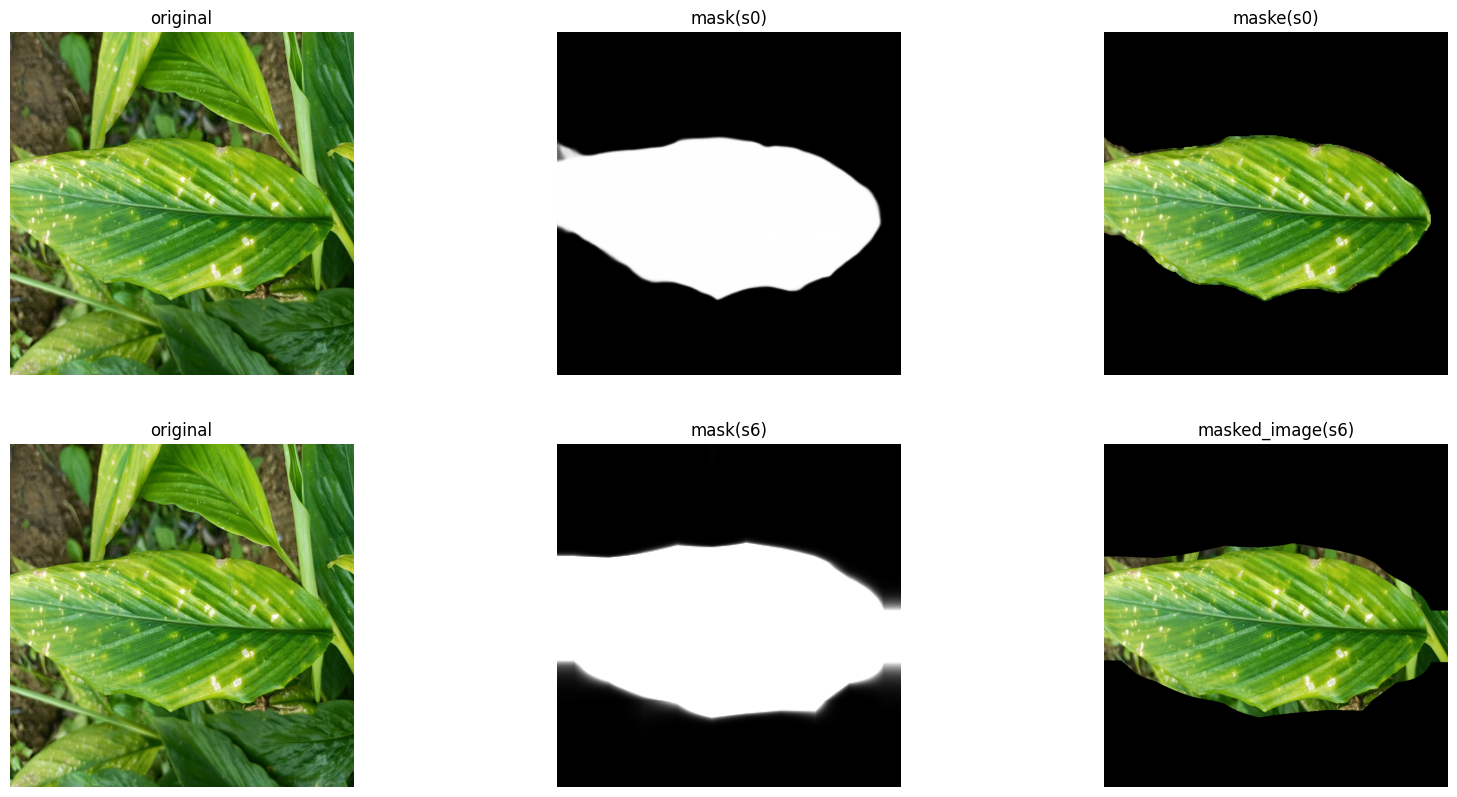

In [7]:
# s(1)mask and masked
temp = S[6]
temp = semanticSegmenter.normPRED(temp[:,0,:,:]).squeeze().cpu().data.numpy() * 255

mask_s6 = cv2.resize(temp,(width,height)).astype(np.uint8)
masked_image_s6 =  cv2.bitwise_and(original,original,mask = mask_s6)

fig = plt.figure(figsize=(20, 10),dpi=100)
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(image)
plt.axis('off')
plt.title("original")

fig.add_subplot(rows, columns, 2)
plt.imshow(mask)
plt.axis('off')
plt.title("mask(s0)")

fig.add_subplot(rows, columns, 3)
plt.imshow(masked)
plt.axis('off')
plt.title("maske(s0)")
cv2.imwrite("sample_masked(s0).jpg", masked)


# np.bitwise_and(original,mask_s1)
# cv2.bitwise_and(original,original,mask = mask_s1)
cv2.imwrite("sample_masked(s6).jpg", masked_image_s6)

fig.add_subplot(rows, columns, 4)
plt.imshow(image)
plt.axis('off')
plt.title("original")

mask_s1 = cv2.cvtColor(temp, cv2. COLOR_GRAY2RGB)
fig.add_subplot(rows, columns, 5)
plt.imshow(mask_s1)
plt.axis('off')
plt.title("mask(s6)")

fig.add_subplot(rows, columns, 6)
plt.imshow(masked_image_s6)
plt.axis('off')
plt.title("masked_image(s6)")

print("Visualization")

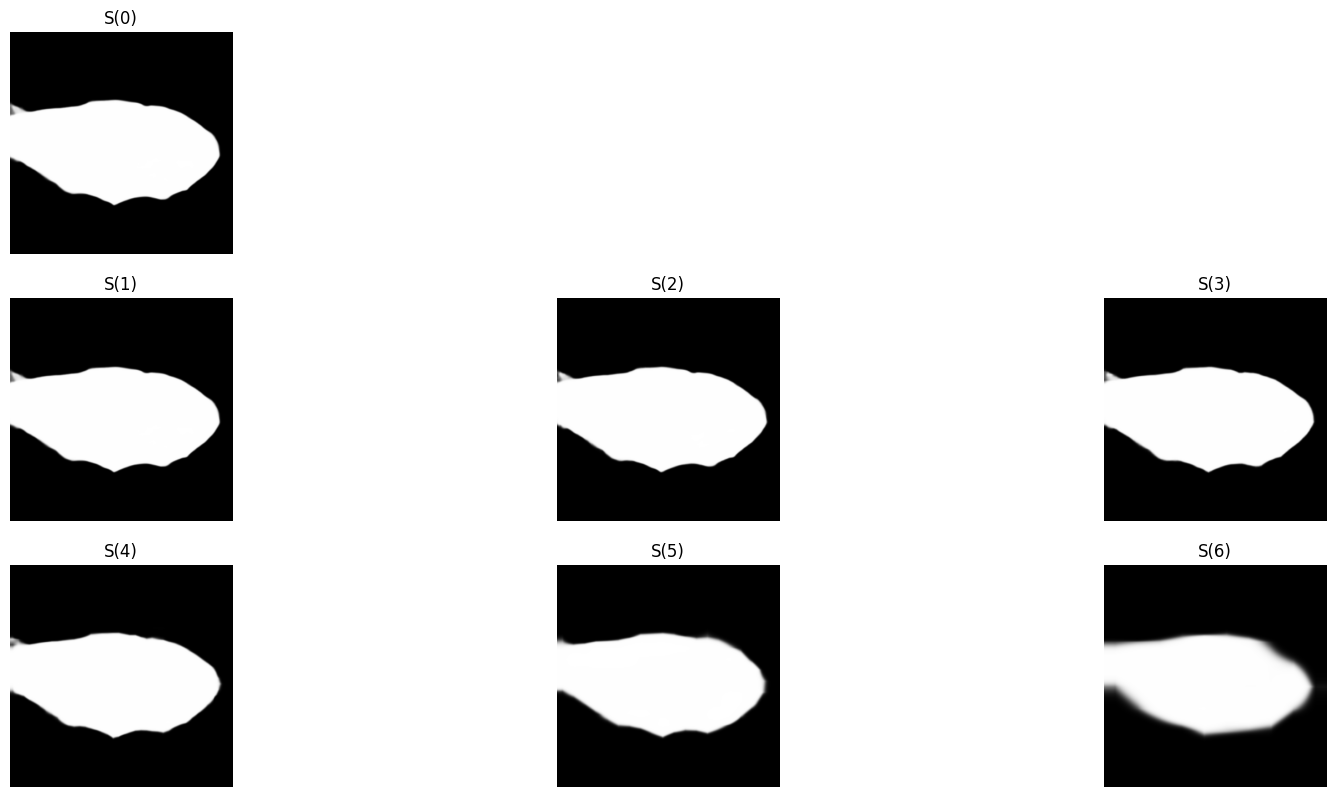

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10),dpi=100)
rows = 3
columns = 3
j = 1
k = 0
for i in S:
  i = semanticSegmenter.normPRED(i[:,0,:,:]).squeeze().cpu().data.numpy() * 255
  i = cv2.resize(i,(width,height),interpolation = cv2.INTER_AREA)
  i = i.astype(np.uint8)
  i = cv2.resize(i,(width//2,height//2))
  i = cv2.cvtColor(i, cv2. COLOR_GRAY2RGB)
  fig.add_subplot(rows, columns, j)
  plt.imshow(i)
  plt.axis('off')
  plt.title("S("+str(k)+")")
  if j==1:
    j=j+2
  j=j+1
  k=k+1

## s6 is blurry because we didnt give spatial info.a

# Segmentation Code(Explanation)
## u2net_util.py
``` python
# utility functions
import gc
import os
import glob
from PIL import Image
from pathlib import Path
from skimage import io, transform


import cv2
import torch
import numpy as np
from models import U2NET
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


class U2NetPrediction:
  model_name = "u2net"
  model_dir = os.path.join(os.getcwd(), 'saved_models', model_name, model_name + '.pth')
  u2net = U2NET(3,1)
  initialized = False

  def __init__(self,transform = None):
    if U2NetPrediction.initialized == False:
      if torch.cuda.is_available():
           U2NetPrediction.u2net.load_state_dict(torch.load(U2NetPrediction.model_dir))
           U2NetPrediction.u2net.cuda()
      else:
           U2NetPrediction.u2net.load_state_dict(torch.load(U2NetPrediction.model_dir, map_location='cpu'))
      U2NetPrediction.initialized = True
    else:
      pass
    U2NetPrediction.u2net.eval()
    self.transform = transform
    self.prediction = None

  # normalize the predicted SOD probability map
  def normPRED(self,d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    del ma,mi
    gc.collect()
    return dn

  def semanticSegmentation(self,image = None,apply_mask=False):
    
    height,width = image.shape[:2]
    
    original = image.copy()
    # apply the trainsformaton to image if transformation present
    if self.transform:
      image = self.transform(image)
    image = image.type(torch.FloatTensor)
    image = image.unsqueeze(0)
    if torch.cuda.is_available():
      image = Variable(image.cuda())
      s1,s2,s3,s4,s5,s6,s7= U2NetPrediction.u2net(image)
    else:
      image = Variable(image)
      s1,s2,s3,s4,s5,s6,s7= U2NetPrediction.u2net(image)
    #seeing the result of each will give idea on how to superimpose and generated mask
    self.S = (s1,s2,s3,s4,s5,s6,s7)

    mask = s1[:,0,:,:]
    mask = self.normPRED(mask)
    mask = mask.squeeze()
    mask_np = mask.cpu().data.numpy()

    mask_np = mask_np*255
    mask_image = cv2.resize(mask_np,(width,height),interpolation = cv2.INTER_AREA)
    mask_image = mask_image.astype(np.uint8)

    if apply_mask:
      masked_image =  cv2.bitwise_and(original,original,mask = mask_image)
    else:
      masked_image = mask_image

    # return only the salicency map to create the mask alone
    # rest availableinthe d1,d2,d3 etc variables
    return masked_image

class RescaleT(object):

    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        self.output_size = output_size

    def __call__(self,image):
        
        h, w = image.shape[:2]

        # if isinstance(self.output_size,int):
        #     if h > w:
        #         new_h, new_w = self.output_size*h/w,self.output_size
        #     else:
        #         new_h, new_w = self.output_size,self.output_size*w/h
        # else:
        #     new_h, new_w = self.output_size
        new_h, new_w = self.output_size,self.output_size
        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image,(new_h,new_w),mode='constant')

        return image



class LeafDataset(Dataset):
    """Plant Leaf dataset Generator"""

    def __init__(self, imagelocationlist, transform=None):
        """
        Args:
        imagelocationlist:- for getting list of images with their location
        transform:- for applying transformation to image
        """
        self.imagelocationlist =imagelocationlist
        self.transform = transform

    def __len__(self):
        return len(self.imagelocationlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = io.imread(self.imagelocationlist[idx])
        imagelocation = self.imagelocationlist[idx]

        if self.transform:
          image = self.transform(image)

        return {'image':image,'imagelocation':imagelocation}                
```
## u2net_SegmentFolders.py
``` python
#for each directory in theimagedir do corresponding outcomein U2NetOUTPUT
import os
import gc
import glob
import shutil
import torch
import cv2
import argparse
import parser
import numpy as np
from PIL import Image
from pathlib import Path
from skimage import io, transform
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from u2net_util import U2NetPrediction,LeafDataset,RescaleT

torch.cuda.empty_cache()
parser = argparse.ArgumentParser(description='Process apply_mask')
parser.add_argument('--apply_mask')
parser.add_argument('--batch_size', type=int, nargs='+',help='an integer for the accumulator')
parser.add_argument('--output_size', type=int, nargs='+',help='output masked image size')

args = vars(parser.parse_args())
apply_mask = args['apply_mask']
batch_size = args['batch_size'][0]
output_size = args['output_size'][0]


mask_interpolation  = cv2.INTER_CUBIC
# output of u2net is 320
# if arg parameter outputsize < 320 we need to enlarge image so we use cv2.INTER_CUBIC
if output_size:
  if output_size < 320:
    mask_interpolation  = cv2.INTER_CUBIC
  else:
    mask_interpolation  = cv2.INTER_AREA

if not batch_size:
  print("Auto assign batch_size = 1")
  batch_size = 1

def save_output(image_location,mask,segmented_dir,apply_mask):
    global mask_interpolation
    mask = mask.squeeze()
    mask_np = mask.cpu().data.numpy()
    if batch_size == 1:
      image_location = '/'.join(image_location)
    else:
      image_location = image_location
    image_name = os.path.basename(image_location)

    mask_np = mask_np*255
    image = cv2.imread(image_location)
    if not output_size:
      mask_image = cv2.resize(mask_np,(image.shape[1],image.shape[0]),interpolation = mask_interpolation)
    else:
      if image.shape[1] < output_size:
        image = cv2.resize(image,(output_size,output_size),interpolation = cv2.INTER_CUBIC)
      else:
        image = cv2.resize(image,(output_size,output_size),interpolation = cv2.INTER_AREA)
      mask_image = cv2.resize(mask_np,(output_size,output_size),interpolation = mask_interpolation)
      
    mask_image = mask_image.astype(np.uint8)
    if apply_mask:
      masked_image = cv2.bitwise_and(image,image,mask = mask_image)
    else:
      masked_image = mask_image

    cv2.imwrite(os.path.join(segmented_dir,"masked_"+image_name),masked_image)
    del masked_image
    gc.collect()

semanticSegmenter = U2NetPrediction()

root_dir = 'data'
output_root_dir = 'output'
skipfolder = {"cardamom_dataset":"Blight1000"}  # already segmented

if not apply_mask:
  output_root_dir = 'output_mask'

if output_size:
  output_root_dir = output_root_dir+'/'+str(output_size)

for datasetSplit in os.listdir(root_dir):
  print("Segmenting:-",datasetSplit)
  for dataset_dir in os.listdir(os.path.join(root_dir,datasetSplit)):
    for labeled_image_dir in os.listdir(os.path.join(root_dir,datasetSplit,dataset_dir)):
      
      image_dir = os.path.join(root_dir,datasetSplit,dataset_dir,labeled_image_dir)
      segmented_dir = os.path.join(output_root_dir,datasetSplit,dataset_dir,labeled_image_dir)
      
      try:
        if skipfolder[datasetSplit] == labeled_image_dir:
          if os.path.exists(segmented_dir):
            shutil.rmtree(segmented_dir, ignore_errors=False, onerror=None)
          shutil.copytree(image_dir, segmented_dir)

          # need to read all the images in the segmented_dir and convert it to
          # argument parameter output_size shape
          if output_size:
            for file1 in os.listdir(segmented_dir):
              segmented_dir_img = segmented_dir+"/"+file1
              img = cv2.imread(segmented_dir_img)
              if img.shape[1] < output_size:
                temp_image_interpolation = cv2.INTER_CUBIC
              else:
                temp_image_interpolation = cv2.INTER_AREA
              img = cv2.resize(img,(output_size,output_size),interpolation = temp_image_interpolation)
              cv2.imwrite(segmented_dir_img,img)
              del img,segmented_dir_img

          print("Copied Already Segmented to output",image_dir)
          continue
      except:
        pass

      Path(segmented_dir).mkdir(parents=True, exist_ok=True)
      img_name_list = glob.glob(image_dir + os.sep + '*')
  
      leaf_dataset = LeafDataset(imagelocationlist = img_name_list,
                                 transform=transforms.Compose([RescaleT(320),
                                                              transforms.ToTensor()])
                                          )
      leaf_dataloader = DataLoader(leaf_dataset,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   num_workers=2)

      for image_data in leaf_dataloader:
        
        image = image_data['image']
        imagelocation = image_data['imagelocation']
        image = image.type(torch.FloatTensor)

        if torch.cuda.is_available():
              inputs_test = Variable(image.cuda())
        else:
              inputs_test = Variable(image)

        s1,s2,s3,s4,s5,s6,s7= semanticSegmenter.u2net(inputs_test)

        #since we included batchsize we need to iterate within batch
        del image
        gc.collect()
        torch.cuda.empty_cache()
        if batch_size !=1:
          for i in range(s1.shape[0]):
            mask = s1[i,0,:,:]
            mask = semanticSegmenter.normPRED(mask)
            save_output(imagelocation[i],mask,segmented_dir,apply_mask)
        else:
          mask = s1[:,0,:,:]
          mask = semanticSegmenter.normPRED(mask)
          save_output(imagelocation,mask,segmented_dir,apply_mask)

        del imagelocation,s1,s2,s3,s4,s5,s6,s7
        gc.collect()
      del leaf_dataloader,leaf_dataset
```

### u2net.py
```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.interpolate(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return torch.sigmoid(d0), torch.sigmoid(d1), torch.sigmoid(d2), torch.sigmoid(d3), torch.sigmoid(d4), torch.sigmoid(d5), torch.sigmoid(d6)

```